## Revisión de Imagenes 360
---


In [1]:
import cv2
import numpy as np
import py360convert
import csv
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#### Funciones

In [20]:
def heatmap_tenengrad(imagen):
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    grad = np.sqrt(gx**2 + gy**2)
    return grad

def detectar_distorsion_simple(zona, min_longitud=150, max_curvatura=0.7, min_contornos_curvos=3, canny1=100, canny2=300):
    """
    Detecta distorsión de bordes de forma rápida:
    - Busca contornos largos y mide su curvatura.
    - Si hay muchos contornos largos y curvos, se considera distorsión.
    """
    gray = cv2.cvtColor(zona, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, canny1, canny2)
    contornos, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contornos_largos = [c for c in contornos if cv2.arcLength(c, False) > min_longitud]
    curvos = 0
    for c in contornos_largos:
        if len(c) > 4:
            [vx, vy, x, y] = cv2.fitLine(c, cv2.DIST_L2, 0, 0.01, 0.01)
            puntos = c.reshape(-1, 2)
            dist = np.abs((vy * (puntos[:,0] - x)) - (vx * (puntos[:,1] - y)))
            curvatura = np.mean(dist)
            if curvatura > max_curvatura * 256:
                curvos += 1
    # Si hay al menos min_contornos_curvos curvos, hay distorsión
    distorsion = curvos >= min_contornos_curvos
    return distorsion, edges

def procesar_imagen(nombre_imagen):
    imagen_path = os.path.join(carpeta, nombre_imagen)
    imagen = cv2.imread(imagen_path)
    if imagen is None:
        return None
    # Menor resolución para más velocidad
    cubemap = py360convert.e2c(imagen, face_w=1024, mode='nearest', cube_format='list')
    distorsion_caras, heatmaps, promedios = [], [], []
    for i in range(4):
        cara = cubemap[i]
        h, w, _ = cara.shape
        x1, x2 = int(w*0.1), int(w*0.9)
        y1, y2 = int(h*0.1), int(h*0.9)
        zona = cara[y1:y2, x1:x2]
        gray = cv2.cvtColor(zona, cv2.COLOR_BGR2GRAY)
        promedios.append(np.mean(gray))
        distorsion, edges = detectar_distorsion_simple(zona)
        distorsion_caras.append(distorsion)
        heatmaps.append(edges)
    promedio_global = np.mean(promedios)
    if promedio_global < 30:
        exposicion_global = "subexpuesta"
    elif promedio_global > 220:
        exposicion_global = "sobreexpuesta"
    else:
        exposicion_global = "correcta"
    distorsion = any(distorsion_caras)
    return {
        'archivo': nombre_imagen,
        'exposicion': exposicion_global,
        'distorsion': distorsion,
        'distorsion_caras': distorsion_caras,
        'heatmaps': heatmaps
    }
    
def chequear_exposicion(imagen, bajo=30, alto=220, pct_umbral=0.5):
    """
    Clasifica la exposición de una imagen:
    - 'subexpuesta' si más del pct_umbral de los pixeles son muy oscuros.
    - 'sobreexpuesta' si más del pct_umbral de los pixeles son muy claros.
    - 'correcta' en caso contrario.
    """
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    pct_bajo = np.mean(gray < bajo)
    pct_alto = np.mean(gray > alto)
    if pct_bajo > pct_umbral:
        return "subexpuesta"
    elif pct_alto > pct_umbral:
        return "sobreexpuesta"
    else:
        return "correcta"

# --- VISUALIZACIÓN DE IMÁGENES Y HEATMAPS PARA LAS 5 MEJORES Y 5 PEORES ---
def mostrar_varias_imagenes(resultados, n=5):
    if not resultados:
        print("No hay imágenes filtradas para mostrar.")
        return
    seleccion = resultados[:n]
    for idx, fila in enumerate(seleccion):
        img_path = os.path.join(carpeta, fila['archivo'])
        img = cv2.imread(img_path)
        if img is not None:
            cubemap = py360convert.e2c(img, face_w=1024, mode='nearest', cube_format='list')
            titulos = ['Frontal', 'Derecha', 'Trasera', 'Izquierda']
            plt.figure(figsize=(16, 4))
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.imshow(cv2.cvtColor(cubemap[i], cv2.COLOR_BGR2RGB))
                plt.title(f"{titulos[i]}\nDistorsión: {fila['distorsion_caras'][i]}")
                plt.axis('off')
            plt.suptitle(
                f"Imagen #{idx+1}: {fila['archivo']} (Distorsión detectada: {fila['distorsion']})"
            )
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        else:
            print(f"No se pudo cargar la imagen {fila['archivo']}.")

# --- HEATMAPS DE LAS 4 VISTAS PARA 5 MEJORES Y 5 PEORES ---
def mostrar_heatmaps(resultados, n=5):
    if not resultados:
        print("No hay imágenes filtradas para mostrar mapa de distorsión.")
        return
    seleccion = resultados[:n]
    titulos = ['Frontal', 'Izquierda', 'Derecha', 'Trasera']
    for idx, fila in enumerate(seleccion):
        plt.figure(figsize=(16, 4))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(fila['heatmaps'][i], cmap='hot')
            plt.title(f"{titulos[i]}\nDistorsión: {fila['distorsion_caras'][i]}")
            plt.axis('off')
        plt.suptitle(
            f"Imagen #{idx+1}: {fila['archivo']} (Distorsión detectada: {fila['distorsion']})"
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [9]:
carpeta = r"D:\Imagenes360\Campamento\2. Fotografias 360"

imagenes = [f for f in os.listdir(carpeta) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
total_imagenes = len(imagenes)

print(f"Total de imágenes a procesar: {total_imagenes}")

start_time = time.time()
resultados = []
procesadas = 0

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    future_to_img = {executor.submit(procesar_imagen, nombre_imagen): nombre_imagen for nombre_imagen in imagenes}
    for idx, future in enumerate(as_completed(future_to_img), 1):
        resultado = future.result()
        if resultado:
            resultados.append(resultado)
        procesadas += 1
        if procesadas % 10 == 0 or procesadas == total_imagenes:
            elapsed = time.time() - start_time
            avg_time = elapsed / procesadas
            remaining = avg_time * (total_imagenes - procesadas)
            print(f"Procesando imagen {procesadas}/{total_imagenes}")
            print(f"Tiempo transcurrido: {elapsed/60:.2f} min")
            print(f"Tiempo estimado restante: {remaining/60:.2f} min")

total_time = time.time() - start_time
print(f"Procesamiento terminado en {total_time/60:.2f} minutos.")

resultados_filtrados = [
    fila for fila in resultados
    if fila['exposicion'] != 'correcta' or fila['distorsion'] is True
]

Total de imágenes a procesar: 1272
Procesando imagen 10/1272
Tiempo transcurrido: 0.28 min
Tiempo estimado restante: 35.96 min
Procesando imagen 20/1272
Tiempo transcurrido: 0.36 min
Tiempo estimado restante: 22.30 min
Procesando imagen 30/1272
Tiempo transcurrido: 0.44 min
Tiempo estimado restante: 18.07 min
Procesando imagen 40/1272
Tiempo transcurrido: 0.56 min
Tiempo estimado restante: 17.13 min
Procesando imagen 50/1272
Tiempo transcurrido: 0.63 min
Tiempo estimado restante: 15.31 min
Procesando imagen 60/1272
Tiempo transcurrido: 0.75 min
Tiempo estimado restante: 15.23 min
Procesando imagen 70/1272
Tiempo transcurrido: 0.84 min
Tiempo estimado restante: 14.46 min
Procesando imagen 80/1272
Tiempo transcurrido: 0.93 min
Tiempo estimado restante: 13.84 min
Procesando imagen 90/1272
Tiempo transcurrido: 1.04 min
Tiempo estimado restante: 13.60 min
Procesando imagen 100/1272
Tiempo transcurrido: 1.13 min
Tiempo estimado restante: 13.23 min
Procesando imagen 110/1272
Tiempo transcurri

#### Resultados

**Exportar CSV**

In [12]:
csv_path = os.path.join(carpeta, 'reporte_distorsion.csv')
campos = [
    'archivo',
    'exposicion',
    'distorsion',
    'distorsion_caras',
]

with open(csv_path, mode='w', newline='', encoding='utf-8') as archivo_csv:
    writer = csv.DictWriter(archivo_csv, fieldnames=campos)
    writer.writeheader()
    for fila in resultados_filtrados:
        writer.writerow({
            'archivo': fila['archivo'],
            'exposicion': fila['exposicion'],
            'distorsion': fila['distorsion'],
            'distorsion_caras': fila['distorsion_caras'],
        })

print("Reporte de nitidez (Tenengrad) guardado en:", csv_path)

Reporte de nitidez (Tenengrad) guardado en: D:\Imagenes360\Campamento\2. Fotografias 360\reporte_distorsion.csv


**Exportar SHP**

In [27]:
# Exportar shapefile filtrado con las imágenes seleccionadas
shp_entrada = os.path.join(carpeta, "Centros_Fotos.shp")
shp_salida = os.path.join(carpeta, "imagenes_filtradas.shp")

if os.path.exists(shp_entrada):
    df_nitidez = pd.read_csv(csv_path)
    if not df_nitidez.empty:
        gdf = gpd.read_file(shp_entrada)
        gdf_filtrado = gdf.merge(df_nitidez, left_on='Nombre', right_on='archivo')
        gdf_filtrado.to_file(shp_salida, driver='ESRI Shapefile')
        print(f"SHP filtrado guardado en {shp_salida}")
    else:
        print("No hay imágenes que cumplan los criterios para exportar SHP.")
else:
    print(f"No se encontró el shapefile de entrada: {shp_entrada}")

SHP filtrado guardado en C:\Users\Juan Camilo\Downloads\Imagenes 360\Chigorodo\2. Fotografias 360\imagenes_filtradas.shp


C:\Users\Juan Camilo\AppData\Local\Temp\ipykernel_17872\3558468565.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_filtrado.to_file(shp_salida, driver='ESRI Shapefile')
c:\Program Files\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'distorsion_caras' to 'distorsi_1'
  ogr_write(


#### Visualizar imagenes

**Ver imagen**

Imagenes aleatorias de muestra:


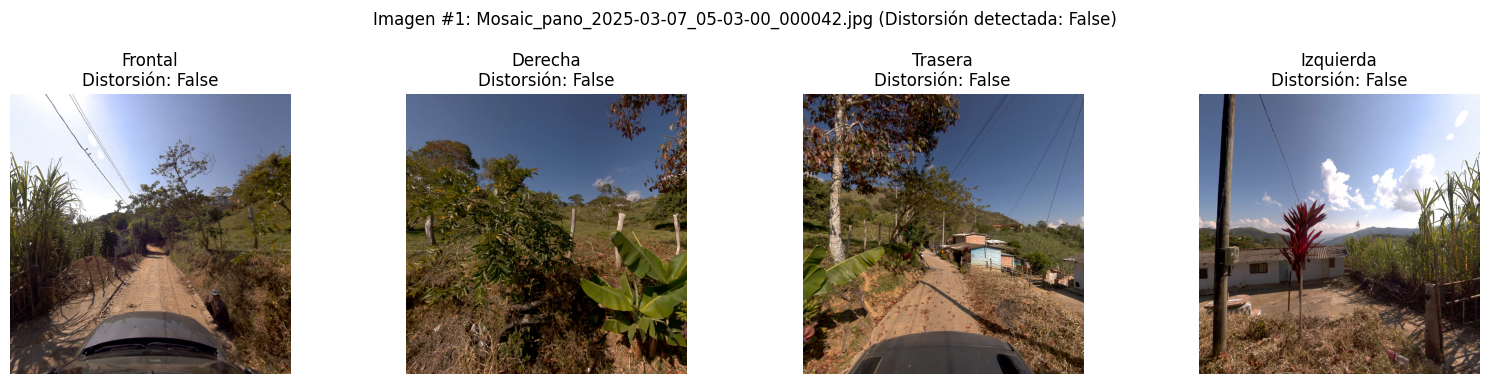

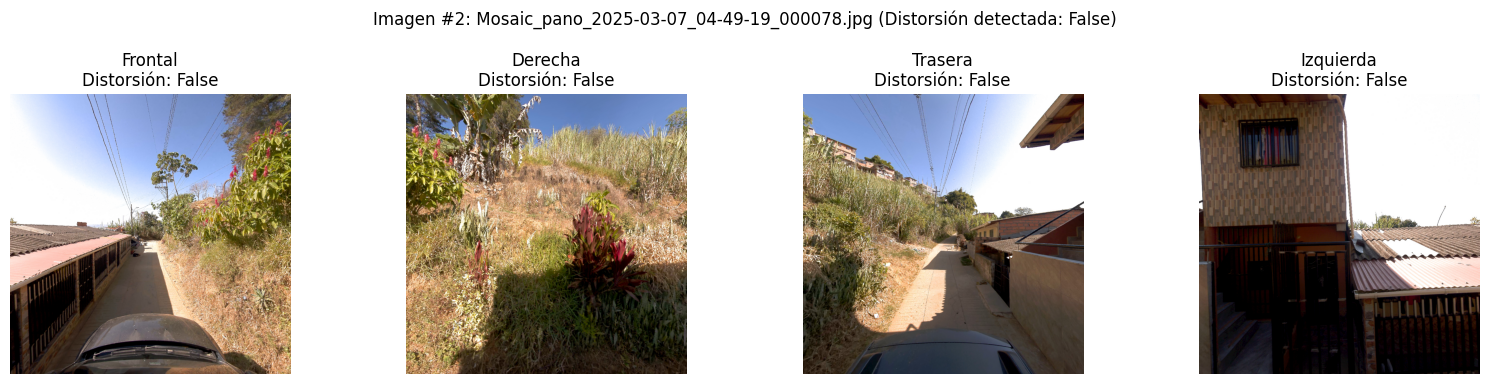

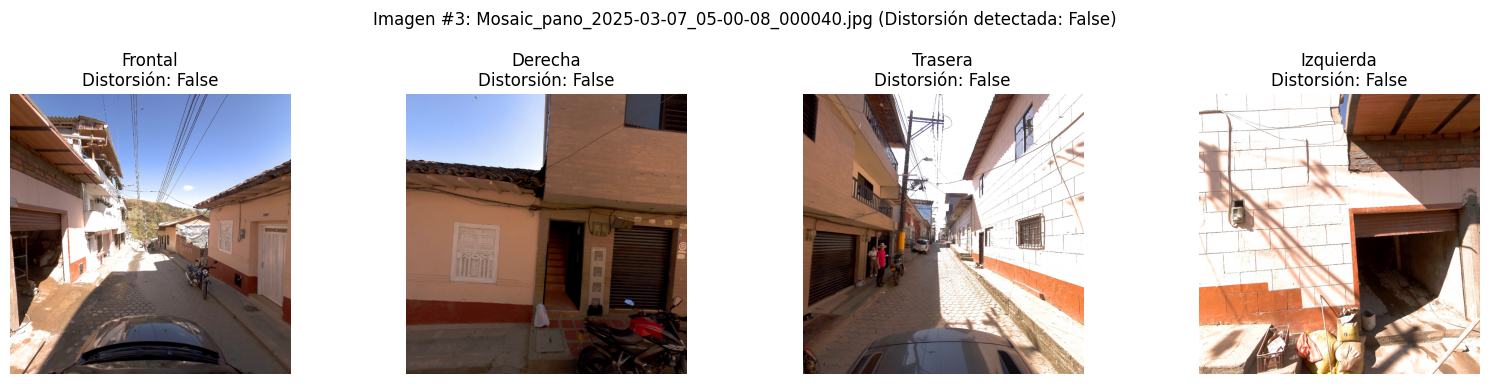

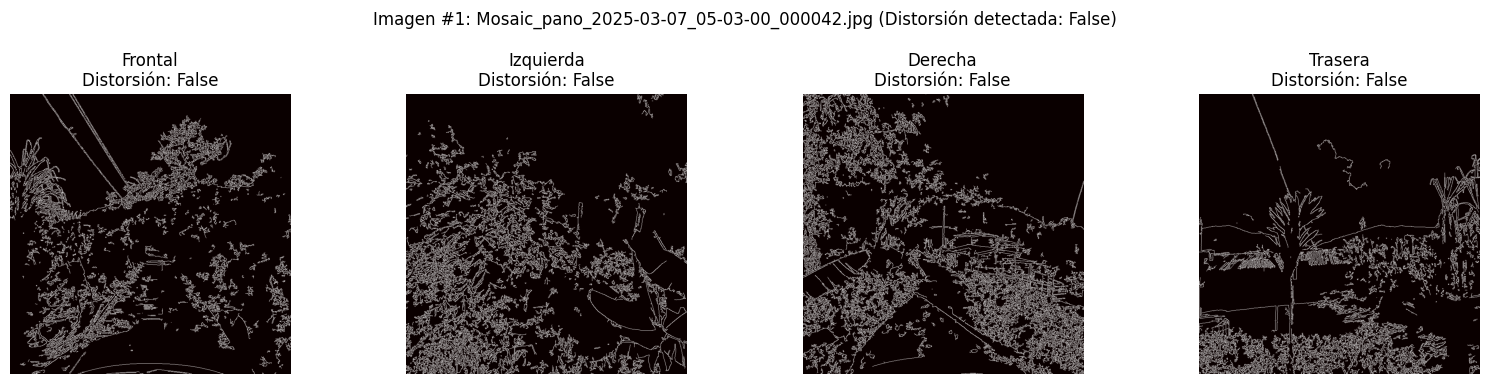

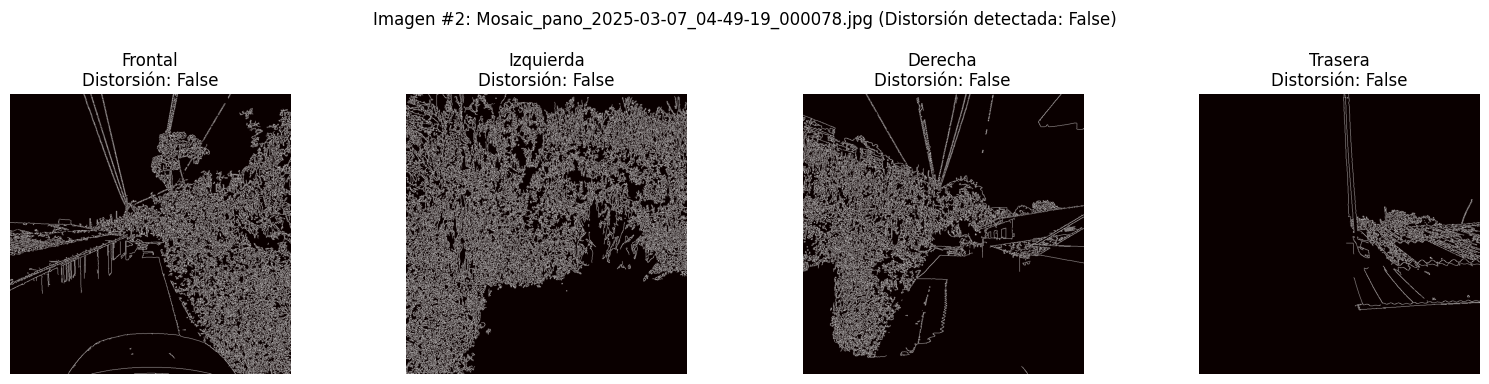

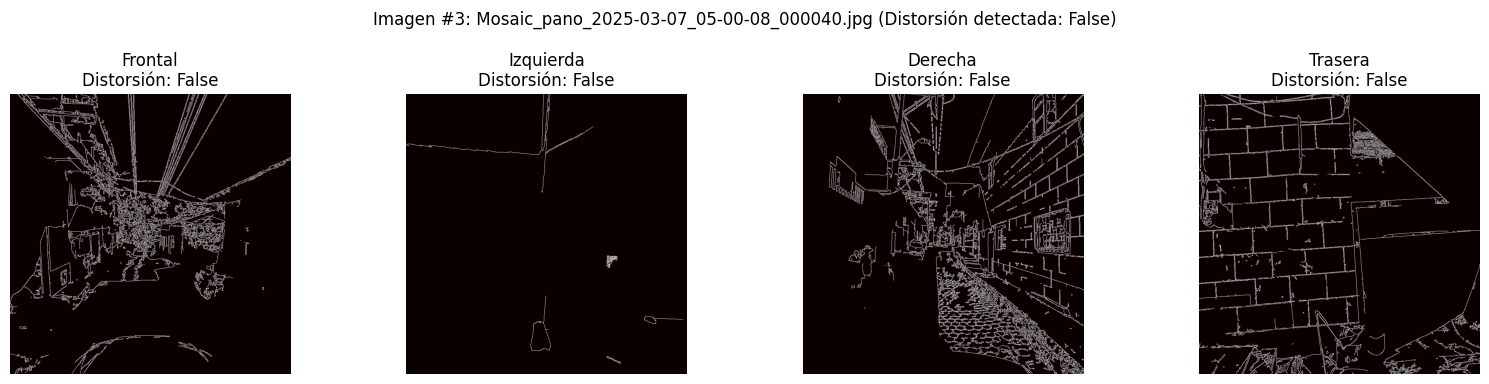

In [19]:
import random
print("Imagenes aleatorias de muestra:")
if len(resultados) >= 3:
    imagen = random.sample(resultados, 3)
else:
    imagen = resultados
mostrar_varias_imagenes(imagen, n=len(imagen))
mostrar_heatmaps(imagen, n=len(imagen))


In [10]:
print("Mostrando las 5 imágenes con distorsión detectada:")
imagenes_con_distorsion = [fila for fila in resultados_filtrados if fila['distorsion'] is True][:5]
mostrar_varias_imagenes(imagenes_con_distorsion, n=5)


Mostrando las 5 imágenes con distorsión detectada:
No hay imágenes filtradas para mostrar.


**Mapa de Calor**

In [11]:
print("Mostrando las 5 imágenes con distorsión detectada:")
imagenes_con_distorsion = [fila for fila in resultados_filtrados if fila['distorsion'] is True][:5]
mostrar_heatmaps(imagenes_con_distorsion, n=5)

Mostrando las 5 imágenes con distorsión detectada:
No hay imágenes filtradas para mostrar mapa de distorsión.
